# kNN Classification for Predicting Hand-written digits

## Summary:



*   Training data is randomly split into training and validation sets with the ratio 75%:25% .
*   Calculating Brute force kNN on entire data is very computationally expensive, hence a subset of data is considered.
*   Various experiments are done on subset of data to find optimal k & distance metric, these are tested against validation test. Final results are measured on given test dataset.
*   Naive brute force won't work on entire dataset, hence vectorization & broadcasting is used to fasten the algorithm. Also, numpy arrays are used instead of pandas dataframes. This improved algorithm speed by at least 100 times.
*   Random classifier is implemented to get a baseline accuracy. Random classifier just selects random class for each test, which gives 10% accuracy, which is expected since there are 10 classes.
*   scikit-learn kNN is also run on the subset and entire dataset for comparison.

## Observations:


* Optimal k range : 1<=k<=9  ( k should be odd )
* Distance metrics performce in the order: Cosine Similarity > Euclidean > Manhatten > Hamming
* All of the distance metrics and K give much better results than baseline random classifier algorithm.
* Using cosine similarity as distance metric, self implemented kNN outperforms scikit-learn kNN also.

## Best Performance Results:

#### Euclidean Distance
K = 1


*   Accuracy : 96.5%

* F-1 score for class with label: 0 is 0.9947
* F-1 score for class with label: 1 is 0.9805
* F-1 score for class with label: 2 is 0.9722
* F-1 score for class with label: 3 is 0.9636
* F-1 score for class with label: 4 is 0.9497
* F-1 score for class with label: 5 is 0.9693
* F-1 score for class with label: 6 is 0.9853
* F-1 score for class with label: 7 is 0.9509
* F-1 score for class with label: 8 is 0.9484
* F-1 score for class with label: 9 is 0.9375

* Mean F-1 score is 0.9652 +/- 0.0175
* Median F-1 score is 0.9664 +/- 0.0161




# Basic kNN




## Train Set Size :

Training on entire data is proving to be very computationally expensive task, hence a subset of training data can be used to calculate distances and find most occuring class.

## Distance Parameter : 

1.   Euclidean Distance 
2.   Manhatten Distance 
3.   Hamming Distance
4.   Cosine Similarity 

## K Parameter : 

1.   K = 5
2.   K = 7
3.   K = 9
4.   K = 11
5.   K = 13

In [0]:
import numpy as np
import pandas as pd
import heapq as hp
import collections as cl

class KNNClassifier:

    def __init__(self, K, p, size):
        self.K = K
        self.size = size
        if p <= 2:
          self.dist = lambda x,y : np.linalg.norm(np.asarray(x)-np.asarray(y),p)
        elif p == 3:
          self.dist = lambda x,y : (np.linalg.norm(x) * np.linalg.norm(y)/np.dot(x, y)) if np.dot(x, y)!=0 else float('Inf')
        
    def train(self,filename):
        if self.size != -1:
          self.train_df = pd.read_csv(filename, header=None).head(self.size)
        else:
          self.train_df = pd.read_csv(filename, header=None)

    def predict(self,filename):
        predict_df = pd.read_csv(filename, header=None)
        predictions = []
        for inp_row in predict_df.itertuples():
            heap = []
            for row in self.train_df.itertuples():
                dis = self.dist(row[2:],inp_row[1:])
                if len(heap) == self.K:
                    hp.heappushpop(heap, (-1*dis, row[1]))
                else:
                    hp.heappush(heap, (-1*dis, row[1]))
            closest_classes = [clos for _,clos in heap]
            predictions += [cl.Counter(closest_classes).most_common(1)[0][0]]
        return predictions
            

### Testing Part : 

Following metrics are calculated to evaluate the performance of the algorithm


*   Accuracy Score
*   F1 Score 
*   Confusion Matrix
*   Accuracy vs K Plot


In [0]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
test_labels = list()

def fone(cur,test_labels,predictions):
  trues = [0]*len(predictions)
  predicteds = [0]*len(predictions)
  for i in range(len(predictions)):
    trues[i] = 1 if test_labels[i] == cur else 0
    predicteds[i] = 1 if predictions[i] == cur else 0
  return f1_score(trues,predicteds)

def calc_mad(x):
  med = np.median(x)
  return med,np.median([abs(i-med) for i in x])

with open("./Datasets/q1/test_labels.csv") as f:
  for line in f:
    test_labels.append(int(line))

def tester(k_list,dist,size):
  if len(k_list) == 0:
    print("ERROR: No K parameters are given")
    return
  if not 0<=dist<4:
    print("ERROR: Invalid Distance parameter flag")
    return
  accuracies = []
  for k in k_list:
    print("K is "+str(k))
    knn_classifier = KNNClassifier(k,dist,size)
    knn_classifier.train('./Datasets/q1/train.csv')
    predictions = knn_classifier.predict('./Datasets/q1/test.csv')
    acc = accuracy_score(test_labels, predictions)
    accuracies += [acc*100]
    print("Accuracy : "+str(acc*100)+"%")
    print("Confusion Matrix:")
    conf = confusion_matrix(test_labels, predictions)
    print("     0   1   2   3   4   5   6   7   8   9")
    for row_label, row in zip(["0","1","2","3","4","5","6","7","8","9"], conf):
      print('%s [%s]' % (row_label, ' '.join('%03s' % i for i in row)))
    print("")
    fone_arr = []
    for i in range(10):
      fone_arr += [fone(i,test_labels,predictions)]
      print("F-1 score for class with label: "+str(i)+" is "+str(fone_arr[-1])[:6])
    print("")
    print("Mean F-1 score is "+str(np.mean(fone_arr))[:6]+" +/- "+str(np.std(fone_arr))[:6])
    med, mad = calc_mad(fone_arr)
    print("Median F-1 score is "+str(med)[:6]+" +/- "+str(mad)[:6])
    print("")
    print("-----------------------------------------------------------------")
    print("")

  if len(k_list) == 1: return
  plt.plot(k_list,accuracies)
  plt.ylabel('Accuracy')
  plt.xlabel('K')
  plt.show()



# Training on subset of dataset:

First parameter of tester is the array of K's on which we want to test

Paramaters : 

*   Array of K's on which we want to test
*   Distance parameter, 0 for Hamming, 1 for Manhatten, 2 for Euclidean and 3 for Cosine Similarity
*   Size of training data to consider, 1<=size<=20000
*   To speed up the calculation part, size = 1000 is considered for training.


##Euclidean Distance :


K is 5
Accuracy : 86.6%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 91   0   0   0   1   0   1   0   1   0]
1 [  0 100   0   1   0   0   0   0   0   0]
2 [  1   9  88   3   1   0   1   2   3   0]
3 [  2   2   1  97   0   2   0   1   2   1]
4 [  0   4   0   0  67   0   2   1   0  17]
5 [  1   4   0  10   0  61   4   0   0   1]
6 [  1   0   0   0   0   1  98   0   1   0]
7 [  0   7   0   0   1   0   0  88   0   8]
8 [  1   3   1   8   1   1   0   1  79   5]
9 [  2   1   1   0   2   0   0   7   2  97]

F-1 score for class with label: 0 is 0.9430
F-1 score for class with label: 1 is 0.8658
F-1 score for class with label: 2 is 0.8844
F-1 score for class with label: 3 is 0.8546
F-1 score for class with label: 4 is 0.8170
F-1 score for class with label: 5 is 0.8356
F-1 score for class with label: 6 is 0.9468
F-1 score for class with label: 7 is 0.8627
F-1 score for class with label: 8 is 0.8404
F-1 score for class with label: 9 is 0.8049

Mean F-1 score is 0.8655 +/- 0.04

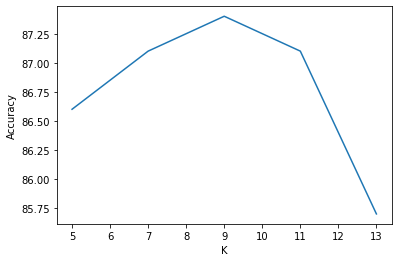

In [0]:
tester([5,7,9,11,13],2,1000)

## Cosine Similarity : 

K is 5
Accuracy : 89.60000000000001%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 90   0   0   1   0   0   2   0   1   0]
1 [  0 100   0   1   0   0   0   0   0   0]
2 [  1   1 100   1   0   0   3   1   1   0]
3 [  3   1   0  96   0   2   0   0   5   1]
4 [  0   3   0   0  72   0   2   2   0  12]
5 [  3   1   0   6   0  63   4   0   4   0]
6 [  2   0   0   0   0   0  99   0   0   0]
7 [  0   6   0   0   1   0   0  88   0   9]
8 [  1   0   3   5   1   0   1   0  87   2]
9 [  3   0   0   0   1   1   0   4   2 101]

F-1 score for class with label: 0 is 0.9137
F-1 score for class with label: 1 is 0.9389
F-1 score for class with label: 2 is 0.9478
F-1 score for class with label: 3 is 0.8807
F-1 score for class with label: 4 is 0.8674
F-1 score for class with label: 5 is 0.8571
F-1 score for class with label: 6 is 0.9339
F-1 score for class with label: 7 is 0.8844
F-1 score for class with label: 8 is 0.87
F-1 score for class with label: 9 is 0.8523

Mean F-1 score is 0.89

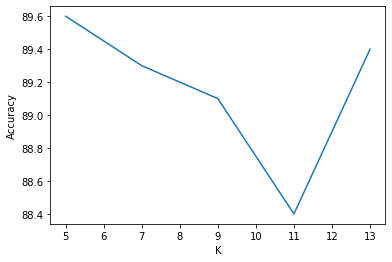

In [0]:
tester([5,7,9,11,13],3,1000)

## Manhatten Distance :


K is 5
Accuracy : 85.6%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 90   0   0   0   1   1   1   1   0   0]
1 [  0 100   0   1   0   0   0   0   0   0]
2 [  1  13  85   3   0   0   1   2   3   0]
3 [  0   3   1  98   0   2   0   1   2   1]
4 [  0   5   0   0  67   0   1   2   0  16]
5 [  0   5   0  12   0  58   5   0   0   1]
6 [  1   3   0   0   0   0  97   0   0   0]
7 [  0   9   0   0   2   0   0  87   0   6]
8 [  1   6   0   6   1   1   0   0  78   7]
9 [  3   1   1   0   3   0   0   7   1  96]

F-1 score for class with label: 0 is 0.9473
F-1 score for class with label: 1 is 0.8130
F-1 score for class with label: 2 is 0.8717
F-1 score for class with label: 3 is 0.8596
F-1 score for class with label: 4 is 0.8121
F-1 score for class with label: 5 is 0.8111
F-1 score for class with label: 6 is 0.9417
F-1 score for class with label: 7 is 0.8529
F-1 score for class with label: 8 is 0.8478
F-1 score for class with label: 9 is 0.8033

Mean F-1 score is 0.8560 +/- 0.04

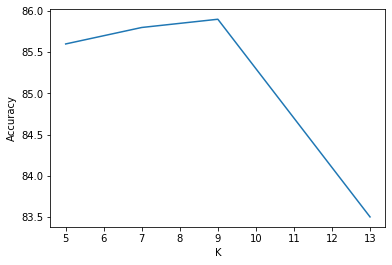

In [0]:
tester([5,7,9,11,13],1,1000)

## Hamming Distance


Obviously hamming distance won't be much useful for this dataset, but still for the comparison

K is 5
Accuracy : 52.0%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 65  24   0   0   0   2   2   1   0   0]
1 [  0 100   0   0   0   0   0   1   0   0]
2 [  0  78  27   0   0   0   0   3   0   0]
3 [  1  60   0  47   0   0   0   0   0   0]
4 [  0  28   0   0  45   0   1   5   0  12]
5 [  0  52   0   5   0  23   1   0   0   0]
6 [  0  38   0   0   0   0  63   0   0   0]
7 [  0  33   0   0   1   0   0  68   0   2]
8 [  0  72   0   2   0   1   1   2  19   3]
9 [  3  21   0   1   5   0   0  19   0  63]

F-1 score for class with label: 0 is 0.7975
F-1 score for class with label: 1 is 0.3294
F-1 score for class with label: 2 is 0.4
F-1 score for class with label: 3 is 0.5766
F-1 score for class with label: 4 is 0.6338
F-1 score for class with label: 5 is 0.4299
F-1 score for class with label: 6 is 0.7455
F-1 score for class with label: 7 is 0.6699
F-1 score for class with label: 8 is 0.3193
F-1 score for class with label: 9 is 0.6562

Mean F-1 score is 0.5558 +/- 0.1647


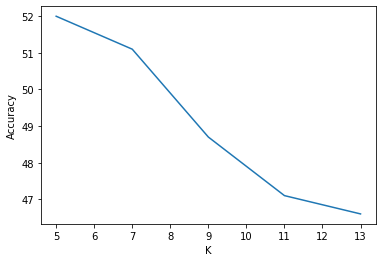

In [0]:
tester([5,7,9,11,13],0,1000)

# Training on entire dataset:

First parameter of tester is the array of K's on which we want to test. So far we have observed that cosine similarity & euclidean distance gives the best results, so we'll use these two distance metrics for the final calculation and we will use K values in [1,3,5,7,9].

Paramaters : 

*   Array of K's on which we want to test : [1,3,5,7,9]
*   Distance parameter : Cosine Similarity ( parameter = 3), Euclidean Distance ( parameter = 2 )
*   Training dataset considered : Entire dataset ( flag = -1 )


### Speeding up kNN



If we continue with for loops and naive distance calculation, training on entire dataset will take lot of time, to speed up the process, we can use vectorized or matrix multiplication method of calculating distances.

Following methods are used to fasten the kNN algorithm:



*   Vectorize the distance metric calculation
*   Use numpy arrays instead of Pandas dataframes
*   Matrix multiplication instead of for loops

After doing these modifications, algorithm time is reduced from hours to few minutes.
Following is the entire code



In [2]:
import numpy as np
import pandas as pd
import heapq as hp
import collections as cl
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class KNNClassifier:

    def train(self,filename):
        data = np.loadtxt(filename, delimiter=',')
        shuffled = data
        np.random.shuffle(shuffled)
        train, test = shuffled[:1500, :], shuffled[1500:, :]
        self.k = 1
        self.dist = 'eucl'
        accuracies = []
        print("Training Cosine Similarity against validation set:")
        for k in range(1,10):
            print("K is ",k)
            self.train_data, self.train_values = train[:,1:], train[:,0]
            acc = accuracy_score(test[:,0],self.predict_data(test[:,1:],k))
            accuracies += [acc]
            print("Accuracy : ", acc)
        print("Training Euclidean distance against validation set:")
        for k in range(1,10):
            print("K is ",k)
            self.train_data, self.train_values = train[:,1:], train[:,0]
            acc = accuracy_score(test[:,0],self.predict_data(test[:,1:],k,'eucl'))
            accuracies += [acc]
            print("Accuracy : ", acc)
        ind = accuracies.index(max(accuracies))
        self.k = ind%10+1
        self.dist = 'eucl' if ind>9 else 'cos'
        dispar = 'Euclidean Distance' if self.dist == 'eucl' else 'Cosine Similarity'
        print("Best Performance is found to be with distance parameter ",dispar," and best k is found to be ",self.k)
        self.train_data, self.train_values = data[:,1:], data[:,0]

    def predict(self, filename):
        return self.predict_data(np.loadtxt(filename, delimiter=','), self.k, self.dist)

    def predict_data(self,test_data, k, dist = 'cos'):
        def cos_sim(A,B):
            normA = np.linalg.norm(A,axis=1)
            normA = normA.reshape(normA.size,1)

            normB = np.linalg.norm(B.T,axis=0)
            normB = normB.reshape(1,normB.size)            
            return np.subtract(1,np.divide(np.matmul(A,B.T),np.matmul(normA,normB)))
                
        def eucl_dis(A, B):
            return -2 * np.dot(A, B.T) + np.sum(B**2, axis=1) + np.sum(A**2, axis=1)[:, np.newaxis]

        if dist == 'cos':
          cosim = cos_sim(test_data,self.train_data)
        elif dist == 'eucl':
          cosim = eucl_dis(test_data,self.train_data)

        top_kvalues = [(hp.nsmallest((k+1), range(len(i)), key=i.take)) for i in cosim]
        return [max(set(self.train_values[np.array(i[:k])]), key=i.count) for i in top_kvalues]

knn_classifier = KNNClassifier()
knn_classifier.train('./Datasets/q1/train.csv')
predictions = knn_classifier.predict('./Datasets/q1/test.csv')
test_labels = list()
with open("./Datasets/q1/test_labels.csv") as f:
  for line in f:
    test_labels.append(int(line))
print("Accuracy score against test dataset:")
print (accuracy_score(test_labels, predictions))

Training Cosine Similarity against validation set:
K is  1
Accuracy :  0.9146486486486487
K is  2
Accuracy :  0.8874594594594595
K is  3
Accuracy :  0.8518918918918919
K is  4
Accuracy :  0.8162162162162162
K is  5
Accuracy :  0.7830810810810811
K is  6
Accuracy :  0.7529189189189189
K is  7
Accuracy :  0.7260540540540541
K is  8
Accuracy :  0.6996756756756757
K is  9
Accuracy :  0.6745945945945946
Training Euclidean distance against validation set:
K is  1
Accuracy :  0.898918918918919
K is  2
Accuracy :  0.8824864864864865
K is  3
Accuracy :  0.8518918918918919
K is  4
Accuracy :  0.8201621621621622
K is  5
Accuracy :  0.79
K is  6
Accuracy :  0.7633513513513513
K is  7
Accuracy :  0.7369189189189189
K is  8
Accuracy :  0.7125405405405405
K is  9
Accuracy :  0.6888108108108109
Best Performance is found to be with distance parameter  Cosine Similarity  and best k is found to be  1
Accuracy score against test dataset:
0.963


In [0]:
import numpy as np
import pandas as pd
import heapq as hp
import collections as cl
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class KNNClassifier:

    def train(self,filename):
        data = np.loadtxt(filename, delimiter=',')
        self.train_data, self.train_values = data[:,1:], data[:,0]

    def predict(self,filename, k, dist = 'cos'):
        test_data = np.loadtxt(filename, delimiter=',')
        def cos_sim(A,B):
            normA = np.linalg.norm(A,axis=1)
            normA = normA.reshape(normA.size,1)

            normB = np.linalg.norm(B.T,axis=0)
            normB = normB.reshape(1,normB.size)            
            return np.subtract(1,np.divide(np.matmul(A,B.T),np.matmul(normA,normB)))
                
        def eucl_dis(A, B):
            return -2 * np.dot(A, B.T) + np.sum(B**2, axis=1) + np.sum(A**2, axis=1)[:, np.newaxis]

        if dist == 'cos':
          cosim = cos_sim(test_data,self.train_data)
        elif dist == 'eucl':
          cosim = eucl_dis(test_data,self.train_data)

        top_kvalues = [(hp.nsmallest((k+1), range(len(i)), key=i.take)) for i in cosim]
        return [max(set(self.train_values[np.array(i[:k])]), key=i.count) for i in top_kvalues]

test_labels = list()

def fone(cur,test_labels,predictions):
  trues = [0]*len(predictions)
  predicteds = [0]*len(predictions)
  for i in range(len(predictions)):
    trues[i] = 1 if test_labels[i] == cur else 0
    predicteds[i] = 1 if predictions[i] == cur else 0
  return f1_score(trues,predicteds)

def calc_mad(x):
  med = np.median(x)
  return med,np.median([abs(i-med) for i in x])

with open("./Datasets/q1/test_labels.csv") as f:
  for line in f:
    test_labels.append(int(line))

def tester():
  eucl_acc = []
  cos_acc = []
  knn_classifier = KNNClassifier()
  knn_classifier.train('./Datasets/q1/train.csv')
  for dist in ['cos','eucl']:
    if dist == 'cos':
        print("Cosine Similarity:")
        print("")
    else:
        print("Euclidean Distance:")
        print("")
    accuracies = []
    for k in range(1,14):
        print("K is "+str(k))      
        predictions = knn_classifier.predict('./Datasets/q1/test.csv', k, dist)
        acc = accuracy_score(test_labels, predictions)
        accuracies += [acc*100]
        print("Accuracy : "+str(acc*100)+"%")
        print("Confusion Matrix:")
        conf = confusion_matrix(test_labels, predictions)
        print("     0   1   2   3   4   5   6   7   8   9")
        for row_label, row in zip(["0","1","2","3","4","5","6","7","8","9"], conf):
            print('%s [%s]' % (row_label, ' '.join('%03s' % i for i in row)))
        print("")
        fone_arr = []
        for i in range(10):
            fone_arr += [fone(i,test_labels,predictions)]
        print("F-1 score for class with label: "+str(i)+" is "+str(fone_arr[-1])[:6])
        print("")
        print("Mean F-1 score is "+str(np.mean(fone_arr))[:6]+" +/- "+str(np.std(fone_arr))[:6])
        med, mad = calc_mad(fone_arr)
        print("Median F-1 score is "+str(med)[:6]+" +/- "+str(mad)[:6])
        print("")
        print("-----------------------------------------------------------------")
        print("")
    if dist == 'eucl':
        eucl_acc = accuracies
    elif dist == 'cos':
        cos_acc = accuracies
  plt.plot(list(range(1,14)),cos_acc, label='Cosine Similarity')
  plt.plot(list(range(1,14)),eucl_acc, label='Euclidean')
  plt.ylabel('Accuracy (%)')
  plt.xlabel('K')
  plt.legend(loc='best')
  plt.show()
tester()

Cosine Similarity:

K is 1
Accuracy : 96.3%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 94   0   0   0   0   0   0   0   0   0]
1 [  0 101   0   0   0   0   0   0   0   0]
2 [  1   0 103   1   0   0   1   1   0   1]
3 [  0   0   1 107   0   0   0   0   0   0]
4 [  0   0   0   0  85   0   1   0   0   5]
5 [  0   0   0   2   0  78   0   0   1   0]
6 [  0   0   0   0   0   0 101   0   0   0]
7 [  0   2   2   0   1   0   0  96   0   3]
8 [  0   1   0   2   0   4   0   0  92   1]
9 [  0   0   1   0   1   0   0   2   2 106]

F-1 score for class with label: 9 is 0.9298

Mean F-1 score is 0.9632 +/- 0.0205
Median F-1 score is 0.9575 +/- 0.0145

-----------------------------------------------------------------

K is 2
Accuracy : 95.6%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 94   0   0   0   0   0   0   0   0   0]
1 [  0 101   0   0   0   0   0   0   0   0]
2 [  1   0 105   0   0   0   0   1   0   1]
3 [  0   0   1 107   0   0   0   0   0   0]
4 [  0

<Figure size 640x480 with 1 Axes>

# Random Guessing




Since we are classifying data into 10 classes, we can take 10% as the baseline accuracy.

Following is an implementation of randomly guessing hand written digit.

In [0]:
import numpy as np
import pandas as pd

class KNNClassifier:

    def __init__(self, K, p, size):
        pass
        
    def train(self,filename):
        pass

    def predict(self,filename):
        predict_df = pd.read_csv(filename, header=None)
        return np.random.randint(0,10,len(predict_df))

For baseline algorithm to randomly decide class, K or distance parameter doesn't matter

In [0]:
tester([7],3,20000)

K is 7
Accuracy : 8.5%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [  8   5  14   9  13   8  12   5  14   6]
1 [  9   8   7  12  13  13   9  11   5  14]
2 [ 14   7   6  13  13  10  13  10  11  11]
3 [ 11  12   9  12   8   9  14  12   8  13]
4 [ 12   6   4   8  12  12  10   7   9  11]
5 [ 10  10   5   8   7   9   6  12   7   7]
6 [  5  11  14  16   7   9   3  13  15   8]
7 [ 10   6  11   9  14  16   8  13   7  10]
8 [  8  12   9   7  11  12  11  11   6  13]
9 [  9  12  15  12  11  12   8   8  17   8]

F-1 score for class with label: 0 is 0.0842
F-1 score for class with label: 1 is 0.0842
F-1 score for class with label: 2 is 0.0594
F-1 score for class with label: 3 is 0.1121
F-1 score for class with label: 4 is 0.1200
F-1 score for class with label: 5 is 0.0942
F-1 score for class with label: 6 is 0.0307
F-1 score for class with label: 7 is 0.1262
F-1 score for class with label: 8 is 0.0603
F-1 score for class with label: 9 is 0.0751

Mean F-1 score is 0.0846 +/- 0.028

# Scikit-learn's kNN Classifier



In [0]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

class KNNClassifier:

    def __init__(self, K, p, size):
        self.neigh = KNeighborsClassifier(n_neighbors=K)
        self.size = size
        
    def train(self,filename):
        if self.size != -1:
          df = pd.read_csv(filename, header=None).head(self.size)
        else:
          df = pd.read_csv(filename, header=None)
        X = df.drop(columns=df.columns[0])
        y = df[df.columns[0]].values
        self.neigh.fit(X, y)

    def predict(self,filename):
        predict_df = pd.read_csv(filename, header=None)
        return self.neigh.predict(predict_df)


### Subset Training Data
size = 1000

K is 3
Accuracy : 88.0%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 92   0   0   0   0   0   1   0   1   0]
1 [  0 100   0   1   0   0   0   0   0   0]
2 [  2   6  97   2   0   0   0   1   0   0]
3 [  1   2   1  98   0   3   0   1   1   1]
4 [  0   5   0   0  70   0   1   2   0  13]
5 [  0   4   0   9   0  65   3   0   0   0]
6 [  1   0   0   0   0   2  97   0   1   0]
7 [  0   9   0   0   0   0   0  87   0   8]
8 [  1   3   3   6   1   0   1   1  79   5]
9 [  4   2   1   1   3   0   0   5   1  95]

F-1 score for class with label: 0 is 0.9435
F-1 score for class with label: 1 is 0.8620
F-1 score for class with label: 2 is 0.9238
F-1 score for class with label: 3 is 0.8711
F-1 score for class with label: 4 is 0.8484
F-1 score for class with label: 5 is 0.8609
F-1 score for class with label: 6 is 0.9509
F-1 score for class with label: 7 is 0.8656
F-1 score for class with label: 8 is 0.8633
F-1 score for class with label: 9 is 0.8119

Mean F-1 score is 0.8801 +/- 0.04

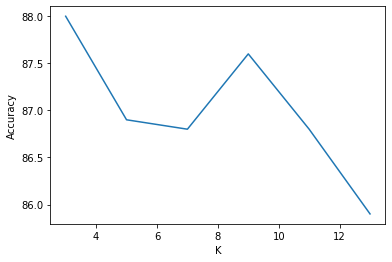

In [0]:
tester([3,5,7,9,11,13],3,1000)

### Train on entire dataset

K is 3
Accuracy : 96.7%
Confusion Matrix:
     0   1   2   3   4   5   6   7   8   9
0 [ 93   0   0   0   0   0   1   0   0   0]
1 [  0 101   0   0   0   0   0   0   0   0]
2 [  0   0 107   0   0   0   0   1   0   0]
3 [  0   0   0 107   0   0   1   0   0   0]
4 [  0   1   0   0  83   0   1   0   0   6]
5 [  0   0   0   1   0  79   0   0   1   0]
6 [  0   0   0   0   0   0 101   0   0   0]
7 [  0   2   1   0   1   0   0  97   0   3]
8 [  1   0   2   2   0   2   0   0  93   0]
9 [  2   0   1   0   1   1   0   1   0 106]

F-1 score for class with label: 0 is 0.9789
F-1 score for class with label: 1 is 0.9853
F-1 score for class with label: 2 is 0.9771
F-1 score for class with label: 3 is 0.9816
F-1 score for class with label: 4 is 0.9431
F-1 score for class with label: 5 is 0.9693
F-1 score for class with label: 6 is 0.9853
F-1 score for class with label: 7 is 0.9556
F-1 score for class with label: 8 is 0.9587
F-1 score for class with label: 9 is 0.9339

Mean F-1 score is 0.9669 +/- 0.01

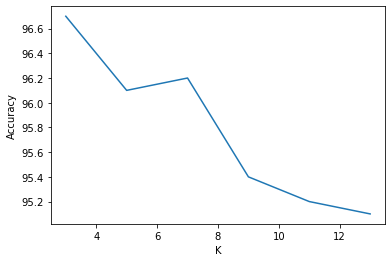

In [0]:
tester([3,5,7,9,11,13],3,-1)